# "СберАвтоподписка": предсказание целевых действий  


**Цель проекта**: предсказать совершения одного из целевых действий - событий типа "Оставить заявку" или "Заказать звонок" для каждой сессии по аттрибутам visit_\*, utm_\*, device_\*, geo_\*.   

**Целевая метрика**: roc-auc > 0.65.

## Настройка ноутбука

### Импорт библиотек





In [1]:
! pip install feature-engine catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 29.8 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
import sys
from datetime import datetime
import warnings
from pathlib import Path
from typing import Union

import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# препроцессинг и метрики
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, precision_score, 
    recall_score, f1_score, make_scorer, roc_curve)
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (
    DropDuplicateFeatures, DropConstantFeatures, 
    DropCorrelatedFeatures, DropFeatures)
from feature_engine.transformation import YeoJohnsonTransformer

# модели
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, HistGradientBoostingClassifier)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# дополнительные данные
from additional_data import (
    get_distance_from_moscow, target_events, missing_values, organic_mediums, 
    social_media_sources, moscow_region_cities, big_cities, russian_holidays)

### Создание констант

In [3]:
# необходимо указать путь к папкам с данными и моделями

data_folder = Path('..', 'data')
models_folder = Path('..', 'models')

sessions_filename = 'ga_sessions.csv'
hits_filename = 'ga_hits.csv'

In [4]:
TEST_SIZE = 200_000
RANDOM_SEED = 0

### Настройка ноутбука

In [5]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [6]:
# для среды google colab
if 'google.colab' in sys.modules: 
    from google.colab import drive
    drive.mount('/content/drive')
    data_folder = Path('drive', 'MyDrive', 'data')
    models_folder = Path('models')

Mounted at /content/drive


### Загрузка данных

Для файла `ga_hits.csv` нужно загрузить только колонки 'session_id' и 'event_action', так как остальные не используются.

In [7]:
sessions = pd.read_csv(data_folder / sessions_filename)
hits = pd.read_csv(data_folder / hits_filename, 
                   usecols=['session_id', 'event_action'])

## Подготовка данных

### Целевая переменная  

Целевая переменная считается положительной, если для сессии из `sessions` есть хотя бы одно целевое событие в `hits`. 

In [8]:
hits['target'] = hits['event_action'].isin(target_events)
is_target_event = hits.groupby('session_id')['target'].any().astype(int)

In [9]:
target = pd.Series(is_target_event, index=sessions['session_id']).fillna(0.0)
target.value_counts(dropna=False, normalize=True)

0.0    0.97295
1.0    0.02705
Name: target, dtype: float64

In [10]:
del hits

### Заполнение пропусков  

Пропуски в колонке `device_screen_resolution` заполняем самым частым значением.  
Все остальные пропуски в колонках заполняем значением '(nan)'.

In [11]:
def fill_missings(data: pd.DataFrame) -> pd.DataFrame:
    """Заполняет пропущенные значения:
    * самым частым значением для `device_screen_resolution`;
    * значением '(nan)' во всех остальных случаях.
    """

    data = data.copy()

    if 'device_screen_resolution' in data.columns:
        # '414x896' - самое частое значение в 'device_screen_resolution'
        # согласно предварительному анализу данных
        data['device_screen_resolution'] = \
            data['device_screen_resolution'].replace(missing_values, '414x896')
    
    return data.fillna('(nan)')

### Генерация признаков

Создаётся множество дополнительных переменных: день недели и день месяца, является ли день выходным, час и минута посещения, ночью ли посещение, ширина, высота, площадь и соотношение экрана.

В том числе с дополнительными данными: является ли день празничным, является ли трафик органическим, из социальных ли сетей он, находится ли пользователь в большом городе или в московской области, расстояние до Москвы как численно, так и в виде категорий.

In [12]:
def distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

In [76]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    """Создаёт новые признаки из существующих."""

    data = data.copy()
    
    # visit_date признаки 
    if 'visit_date' in data.columns:
        data['visit_date'] = data['visit_date'].astype('datetime64[ns]')
        data['visit_date_added_holiday'] = \
            data['visit_date'].isin(russian_holidays)
        # числовые признаки сделаем строго положительными 
        # для лучшей обработки на шаге с YeoJohnsonTransformer
        data['visit_date_weekday'] = data['visit_date'].dt.weekday + 1
        data['visit_date_weekend'] = data['visit_date'].dt.weekday > 4
        data['visit_date_day'] = data['visit_date'].dt.day + 1

    # visit_time признаки
    if 'visit_time' in data.columns:
        data['visit_time'] = data['visit_time'].astype('datetime64[ns]')
        data['visit_time_hour'] = data['visit_time'].dt.hour + 1
        data['visit_time_minute'] = data['visit_time'].dt.minute + 1
        data['visit_time_night'] = data['visit_time'].dt.hour < 9

    # utm_* признаки
    if 'utm_medium' in data.columns:
        data['utm_medium_added_is_organic'] = \
            data['utm_medium'].isin(organic_mediums)
    if 'utm_source' in data.columns: 
        data['utm_source_added_is_social'] = \
            data['utm_source'].isin(social_media_sources)
    
    # device_screen признаки
    if 'device_screen_resolution' in data.columns:
        name = 'device_screen_resolution'
        data[[name + '_width', name + '_height']] = \
            data[name].str.split('x', expand=True).astype(float)
        data[name + '_area'] = data[name + '_width'] * data[name + '_height']
        data[name + '_ratio'] = data[name + '_width'] / data[name + '_height']
        data[name + '_ratio_greater_1'] = data[name + '_ratio'] > 1

    # geo_city признаки 
    if 'geo_city' in data.columns:
        data['geo_city_added_is_moscow_region'] = \
            data['geo_city'].isin(moscow_region_cities)
        data['geo_city_added_is_big'] = data['geo_city'].isin(big_cities)
        data['geo_city_is_big_or_in_moscow_region'] = \
            data['geo_city_added_is_moscow_region'] \
            | data['geo_city_added_is_big']
        data['geo_city_added_distance_from_moscow'] = \
            data['geo_city'].apply(get_distance_from_moscow)
        data['geo_city_added_distance_from_moscow_category'] = \
            data['geo_city_added_distance_from_moscow'].apply(distance_category)

    return data

### Дополнительно

In [14]:
def set_index(data: pd.DataFrame, column: str = 'session_id') -> pd.DataFrame:
    """Устанавливает в качестве индекса датафрейма колонку `column`."""
    
    data = data.copy()

    if column in data.columns:
        data = data.set_index(column)
    
    return data

In [15]:
def converse_types(data: pd.DataFrame) -> pd.DataFrame:
    """Приводит типы переменных к float. В первую очередь 
    необходимо для преобразования bool значений.
    """

    return data.astype(float)

### Сбор конвейера  

Конвейер по подготовке данных состоит из 4 частей:  
1. Создание дополнительных признаков
2. Преобразование численных переменных
3. Преобразование категориальных переменных
4. Удаление лишних признаков

In [16]:
preprocessor = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.05, replace_with='rare')), 
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.99)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8)), 

])

## Моделирование

### Разделение данных  

Разделим данные на тренировочную, валидационную и тестовую выборки.  


In [17]:
X, X_test, y, y_test = train_test_split(
    sessions, target, test_size=TEST_SIZE, 
    stratify=target, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, 
    stratify=y, random_state=RANDOM_SEED)

print(f'train shapes: {X_train.shape} {y_train.shape}')
print(f'valid shapes: {X_valid.shape} {y_valid.shape}')
print(f'test  shapes: {X_test.shape} {y_test.shape}')

train shapes: (1460042, 18) (1460042,)
valid shapes: (200000, 18) (200000,)
test  shapes: (200000, 18) (200000,)


### Препроцессинг данных  

Преобразуем тренировочные и валидационные данные с помощью построенного конвейера.

In [18]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

print(f'X_train.shape = {X_train_preprocessed.shape}')

X_train.shape = (1460042, 55)


### Выбор метрик  

Будем использовать в качестве основной метрики - `roc_auc`. Но также взглянем и на другие метрики: `accuracy`, `precision`, `recall`, `f1`.  


In [19]:
def find_best_threshold(
    y_true: pd.Series, 
    y_proba: pd.Series, 
    metriс_name: str = 'roc_auc', 
    iterations: int = 250, 
    learning_rate: float = 0.05
) -> float:
    """Находит лучший порог перевода вероятностей `y_proba` 
    в принадлежность к классу 1.
    """
    
    # Получение функции метрики, которую оптимизируем
    metrics = {'roc_auc': roc_auc_score, 'f1': f1_score, 
               'precision': precision_score, 'recall': recall_score}
    metric_function = metrics.get(metriс_name, accuracy_score)

    # Получение метрики
    def get_metric(threshold: float) -> float:
        prediction = (y_proba > threshold).astype(int)
        return metric_function(y_true, prediction)

    direction = -1
    shift = 0.25

    best_threshold = 0.5
    best_metric = get_metric(best_threshold)

    # На каждой итерации
    for i in range(iterations):

        # Меняем порог
        threshold = best_threshold + direction * shift
        shift *= (1 - learning_rate)
        metric = get_metric(threshold)

        # И проверяем, улучшилась ли метрика
        if metric > best_metric: 
            best_threshold = threshold
            best_metric = metric
        else: 
            direction *= -1
            
    return best_threshold

In [20]:
def print_metrics(
    model: BaseEstimator, 
    X: pd.DataFrame, 
    y: pd.Series, 
    threshold: Union[float, None] = None, 
    show_roc_curve: bool = False
) -> None:
    """Получает метрики бинарной классификации из модели `model` на данных 
    `X` и `y`. Если возможно, то через метод `predict_proba` с заданным 
    порогом перевода вероятностей в классы `threshold`, иначе через `predict`. 
    Если `threshold` равен None, автоматически найдёт лучший порог.  
    ---
    Метрики: roc_auc, accuracy, precision, recall, f1, confusion_matrix, 
    roc_curve.
    """

    # Получим предсказания, если возможно в виде вероятностей
    try: 
        probas = model.predict_proba(X)[:, 1]
    except AttributeError:
        prediction = model.predict(X)
        threshold = None
        probas = None
    else:
        threshold = threshold or find_best_threshold(y, probas, 'roc_auc')
        prediction = (probas > threshold).astype(int)

    # Распечатаем порог перевода вероятностей в классы
    if threshold is None:
        print("Порог перевода вероятностей в классы: не используется")
    else:
        print(f"Порог перевода вероятностей в классы: {threshold}")
        print(f"{roc_auc_score(y, probas)} - roc_auc на вероятностях")

    # Распечатаем однострочные метрики
    print()
    print(f"{roc_auc_score(y, prediction):0.8f} - roc_auc")
    print(f"{accuracy_score(y, prediction):0.8f} - accuracy")
    print(f"{precision_score(y, prediction):0.8f} - precision")
    print(f"{recall_score(y, prediction):0.8f} - recall")
    print(f"{f1_score(y, prediction):0.8f} - f1")

    # Распечатаем матрицу ошибок
    conf_mat = confusion_matrix(y, prediction)
    classes = model.classes_
    n_classes = len(classes)
    print()
    print("|".join(f"{i:^10}" for i in ["prediction"] + list(classes)))
    print(f"{'true label':^10}" + ("|" + " " * 10) * n_classes)
    print("-" * ((n_classes * 10) + n_classes + 10))
    for i in range(n_classes):
        print("|".join(f"{j:>10}" for j in [classes[i]] + list(conf_mat[i])))

    # Отобразим ROC-кривую
    if show_roc_curve:
        print()
        plt.figure(figsize=(7, 4))
        if probas is not None:
            plt.plot(*roc_curve(y_test, probas)[:2], 
                     c='r', label='on probability')
        plt.plot(*roc_curve(y_test, prediction)[:2], c='b', label='on class')
        plt.plot([0, 1], [0, 1], c='y', label='random', linestyle='dashed')
        plt.title('Receiver operating characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

### Базовая модель  

Так как целевая переменная распределена не равномерно, то в качестве бейзлайна можно выбрать стратегию, которая для каждой сессии предсказывает значение 0.  


In [21]:
# Обучим базовую модель 
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(X_train_preprocessed, y_train)

# И получим её метрики
print_metrics(baseline, X_valid_preprocessed, y_valid, 0.5)

Порог перевода вероятностей в классы: 0.5
0.5 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


### Выбор модели  

Обучим несколько моделей, оценим на валидационной выборке и выберем лучшую, которую уже будем оптимизировать.

Логистическая регрессия

In [22]:
logreg = LogisticRegression(random_state=RANDOM_SEED)

In [23]:
%%time
logreg.fit(X_train_preprocessed, y_train);

CPU times: user 51.2 s, sys: 14.7 s, total: 1min 5s
Wall time: 35.5 s


LogisticRegression(random_state=0)

In [24]:
print_metrics(logreg, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.5
0.6683645085705108 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


Метод опорных векторов

In [25]:
svc = LinearSVC(class_weight='balanced', dual=False)

In [26]:
%%time
svc.fit(X_train_preprocessed, y_train);

CPU times: user 39.3 s, sys: 115 ms, total: 39.4 s
Wall time: 40 s


LinearSVC(class_weight='balanced', dual=False)

In [27]:
print_metrics(svc, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: не используется

0.61920276 - roc_auc
0.56131000 - accuracy
0.04104136 - precision
0.68040665 - recall
0.07741325 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    108581|     86009
       1.0|      1729|      3681


Нейронная сеть

In [28]:
mlp = MLPClassifier((32,), random_state=RANDOM_SEED)

In [29]:
%%time
mlp.fit(X_train_preprocessed, y_train);

CPU times: user 3min 16s, sys: 2min 29s, total: 5min 46s
Wall time: 3min 1s


MLPClassifier(hidden_layer_sizes=(32,), random_state=0)

In [30]:
print_metrics(mlp, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.5
0.6983782119645087 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


Байесовский классификатор

In [31]:
gaussnb = GaussianNB()

In [32]:
%%time
gaussnb.fit(X_train_preprocessed, y_train);

CPU times: user 1.82 s, sys: 55.8 ms, total: 1.87 s
Wall time: 1.87 s


GaussianNB()

In [33]:
print_metrics(gaussnb, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.05419511287276451
0.6458839691283222 - roc_auc на вероятностях

0.60928251 - roc_auc
0.56001500 - accuracy
0.03986940 - precision
0.66136784 - recall
0.07520520 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    108425|     86165
       1.0|      1832|      3578


Дерево решений

In [34]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

In [35]:
%%time
tree.fit(X_train_preprocessed, y_train);

CPU times: user 41.1 s, sys: 491 ms, total: 41.6 s
Wall time: 41.5 s


DecisionTreeClassifier(random_state=0)

In [36]:
print_metrics(tree, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.033708156968674276
0.5204877305418407 - roc_auc на вероятностях

0.52080171 - roc_auc
0.93335000 - accuracy
0.05183341 - precision
0.08465804 - recall
0.06429875 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    186212|      8378
       1.0|      4952|       458


Случайный лес

In [37]:
forest = RandomForestClassifier(random_state=RANDOM_SEED)

In [38]:
%%time
forest.fit(X_train_preprocessed, y_train);

CPU times: user 8min 4s, sys: 3.31 s, total: 8min 8s
Wall time: 8min 12s


RandomForestClassifier(random_state=0)

In [39]:
print_metrics(forest, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.010218123817113232
0.6253519433580381 - roc_auc на вероятностях

0.59594638 - roc_auc
0.59998000 - accuracy
0.03952047 - precision
0.59168207 - recall
0.07409208 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    116795|     77795
       1.0|      2209|      3201


Градиентный Бустинг

In [40]:
histboost = HistGradientBoostingClassifier(random_state=RANDOM_SEED)

In [41]:
%%time
histboost.fit(X_train_preprocessed, y_train);

CPU times: user 1min 33s, sys: 632 ms, total: 1min 34s
Wall time: 53.5 s


HistGradientBoostingClassifier(random_state=0)

In [42]:
print_metrics(histboost, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.02822602984682529
0.70696812360298 - roc_auc на вероятностях

0.64682393 - roc_auc
0.62957000 - accuracy
0.04742197 - precision
0.66506470 - recall
0.08853129 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    122316|     72274
       1.0|      1812|      3598


CatBoost

In [43]:
catboost = CatBoostClassifier(
    iterations=100, verbose=False, random_state=RANDOM_SEED)

In [44]:
%%time
catboost.fit(X_train_preprocessed, y_train);

CPU times: user 1min 3s, sys: 767 ms, total: 1min 4s
Wall time: 33.5 s


In [45]:
print_metrics(catboost, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.02483463079565137
0.706237016756118 - roc_auc на вероятностях

0.64842106 - roc_auc
0.57463000 - accuracy
0.04490197 - precision
0.72643253 - recall
0.08457615 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    110996|     83594
       1.0|      1480|      3930


XGBoost

In [46]:
xgboost = XGBClassifier()

In [47]:
%%time
xgboost.fit(X_train_preprocessed.values, y_train.values);

CPU times: user 4min 24s, sys: 1.78 s, total: 4min 26s
Wall time: 4min 25s


XGBClassifier()

In [48]:
print_metrics(xgboost, X_valid_preprocessed.values, y_valid.values)

Порог перевода вероятностей в классы: 0.030991801262137603
0.6860580272147163 - roc_auc на вероятностях

0.63026024 - roc_auc
0.65154000 - accuracy
0.04640266 - precision
0.60776340 - recall
0.08622227 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    127020|     67570
       1.0|      2122|      3288


LGBMClassifier

In [49]:
lightgbm = LGBMClassifier(random_state=RANDOM_SEED)

In [50]:
%%time
lightgbm.fit(X_train_preprocessed, y_train);

CPU times: user 32.7 s, sys: 120 ms, total: 32.8 s
Wall time: 32.7 s


LGBMClassifier(random_state=0)

In [51]:
print_metrics(lightgbm, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.02748186954550582
0.7065616093708189 - roc_auc на вероятностях

0.64728889 - roc_auc
0.61351500 - accuracy
0.04660873 - precision
0.68299445 - recall
0.08726251 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    119008|     75582
       1.0|      1715|      3695


### Оптимизация модели  

Лучшей моделью является LightGBM по следующим причинам:
+ Один из лучших показателей `roc_auc`.
+ Быстрое обучение. 
+ Модель интерпретируема, то есть можно получить показатели важности признаков.
+ Может предсказывать вероятность класса.
+ Нет проблем с процессорами без SSE4 как у CatBoost.

Будем оптимизировать гиперпараметры как модели, так и конвейера подготовки данных. GridSearchCV занимает очень большое количество времени, поэтому проведено множество экспериментов вручную для нахождения лучших гиперпараметров.

In [77]:
final_pipeline = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.05, replace_with='rare')),
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.99)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.95)), 

    # Лучшая модель с оптимизированными гиперпараметрами
    ('model', LGBMClassifier(
        n_estimators=800, learning_rate=0.07, reg_lambda=10, num_leaves=26,
        reg_alpha=10, boosting_type='goss', random_state=RANDOM_SEED)), 
    
])

In [78]:
final_pipeline.fit(X_train, y_train);

In [79]:
print('Метрики оптимизированной модели на валидационных данных:')
print_metrics(final_pipeline, X_valid, y_valid)

Метрики оптимизированной модели на валидационных данных:
Порог перевода вероятностей в классы: 0.02644111810424645
0.7142453372981288 - roc_auc на вероятностях

0.65238057 - roc_auc
0.60996000 - accuracy
0.04706646 - precision
0.69722736 - recall
0.08818029 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    118220|     76370
       1.0|      1638|      3772


## Оценка модели

### Метрики модели

Для оценки метрик модели обучим её на объектах тренировочной и валидационной выборках и сделаем предсказания на тестовых данных. 

Целевая метрика `roc-auc=0.6535` (для пресказанных классов) выбранной модели превосходит 0.65, а значит, цель работы выполнена.

Хотя метрика `f1=0.0871` довольно низкая, что неудивительно при большом количестве неверно классиифцированных объектов нулевого класса.

У модели не наблюдается переобучение.

In [55]:
final_pipeline.fit(X, y);

In [56]:
test_proba = final_pipeline.predict_proba(X_test)[:, 1]
best_threshold = find_best_threshold(y_test, test_proba)
test_prediction = (test_proba > best_threshold).astype(int)

print(f'Лучший порог перевода вероятностей в класс: {best_threshold}')

Лучший порог перевода вероятностей в класс: 0.025744147983880847


In [57]:
print(f'Метрики лучшей модели на обучающей выборке:')
print_metrics(final_pipeline, X, y, best_threshold)

Метрики лучшей модели на обучающей выборке:
Порог перевода вероятностей в классы: 0.025744147983880847
0.7418431169043894 - roc_auc на вероятностях

0.67197621 - roc_auc
0.59690960 - accuracy
0.04877414 - precision
0.75133618 - recall
0.09160181 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    957157|    657981
       1.0|     11166|     33738


Метрики лучшей модели на тестовой выборке:
Порог перевода вероятностей в классы: 0.025744147983880847
0.7148069233011747 - roc_auc на вероятностях

0.65352572 - roc_auc
0.59365500 - accuracy
0.04637924 - precision
0.71682070 - recall
0.08712160 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    114853|     79737
       1.0|      1532|      3878



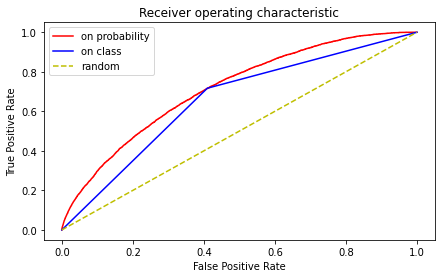

In [58]:
print(f'Метрики лучшей модели на тестовой выборке:')
print_metrics(
    final_pipeline, X_test, y_test, best_threshold, show_roc_curve=True)

### Обучение на всех данных

Для анализа обработки данных и важности признаков разобъём финальный конвейер на препроцессор и модель и обучим их на всех данных. А перед сохранением модели объединим обратно.

In [59]:
final_model = final_pipeline.named_steps['model']
final_preprocessor = final_pipeline.set_params(model=None)

In [60]:
sessions_preprocessed = final_preprocessor.fit_transform(sessions)

In [61]:
final_model.fit(sessions_preprocessed, target);

### Анализ обработки данных

В итоге всех преобразований получается 67 признаков, при том, что ещё 8 признаков были удалены из-за корреляций и т.п..

Датасет имеет 175 787 дубликатов, но как показали эксперименты, удаление дубликатов из тренировочной выборки ведёт к небольшому ухудшению метрик. 

Признаков, коррелируемых с целевой переменной, нет.

In [62]:
sessions_preprocessed.head()

,visit_number,visit_date_added_holiday,visit_date_weekday,visit_date_weekend,visit_date_day,visit_time_hour,visit_time_minute,visit_time_night,utm_medium_added_is_organic,utm_source_added_is_social,device_screen_resolution_width,device_screen_resolution_height,device_screen_resolution_ratio,device_screen_resolution_ratio_greater_1,geo_city_added_is_moscow_region,geo_city_added_is_big,geo_city_is_big_or_in_moscow_region,geo_city_added_distance_from_moscow,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_source_MvfHsxITijuriZxsqZqt,utm_source_kjsLglQLzykiRbcDiGcD,utm_source_rare,utm_source_fDLlAcSmythWSCVMvqvL,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_bByPQxmDaMXgpHeypKSM,utm_medium_banner,utm_medium_cpm,utm_medium_cpc,utm_medium_rare,utm_medium_referral,utm_campaign_LEoPHuyFvzoNfnzGgfcd,utm_campaign_FTjNLDyTrXaWYgZymFkV,utm_campaign_(nan),utm_campaign_LTuZkdKfxRGVceoWkVyg,utm_campaign_gecBYcKZCPMcVYdSSzKP,utm_campaign_rare,utm_adcontent_vCIpmpaGBnIQhyYNkXqp,utm_adcontent_xhoenQgDQsgfEPYNPwKO,utm_adcontent_rare,utm_adcontent_(nan),utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_puhZPIYqKXeFPaUviSjo,utm_keyword_rare,utm_keyword_(nan),device_category_mobile,device_os_Android,device_os_iOS,device_os_rare,device_brand_Huawei,device_brand_Samsung,device_brand_Xiaomi,device_brand_Apple,device_brand_rare,device_browser_Chrome,device_browser_rare,device_browser_Safari,device_browser_YaBrowser,geo_country_Russia,geo_city_rare,geo_city_Moscow,geo_city_Saint Petersburg,geo_city_added_distance_from_moscow_category_1000-3000 km,geo_city_added_distance_from_moscow_category_>= 3000 km,geo_city_added_distance_from_moscow_category_500-1000 km,geo_city_added_distance_from_moscow_category_100-500 km,geo_city_added_distance_from_moscow_category_< 100 km,geo_city_added_distance_from_moscow_category_no distance
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9055434745589932991.1637753792.1637753792,-0.585990,0.0,-0.311302,0.0,0.803575,0.014750,1.339048,0.0,0.0,0.0,-0.829017,-0.686586,-0.311484,0.0,0.0,0.0,0.0,1.193088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
905544597018549464.1636867290.1636867290,-0.585990,0.0,1.485929,1.0,-0.307346,-0.957672,1.163018,1.0,0.0,1.0,-0.447866,0.183252,-0.789287,0.0,0.0,1.0,1.0,-0.885489,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9055446045651783499.1640648526.1640648526,-0.585990,0.0,-0.877065,0.0,1.234404,-1.803240,1.382257,1.0,0.0,0.0,-0.829017,-0.686586,-0.311484,0.0,0.0,1.0,1.0,1.407094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9055447046360770272.1622255328.1622255328,-0.585990,0.0,1.084097,1.0,1.341147,-1.400897,-0.822162,1.0,0.0,0.0,-0.342270,-0.242671,-0.311484,0.0,0.0,1.0,1.0,-0.885489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9055447046360770272.1622255345.1622255345,1.373905,0.0,1.084097,1.0,1.341147,-1.400897,-0.822162,1.0,0.0,0.0,-0.342270,-0.242671,-0.311484,0.0,0.0,1.0,1.0,-0.885489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
sessions_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860042 entries, 9055434745589932991.1637753792.1637753792 to 9055430416266113553.1640968742.1640968742
Data columns (total 67 columns):
 #   Column                                                     Dtype  
---  ------                                                     -----  
 0   visit_number                                               float64
 1   visit_date_added_holiday                                   float64
 2   visit_date_weekday                                         float64
 3   visit_date_weekend                                         float64
 4   visit_date_day                                             float64
 5   visit_time_hour                                            float64
 6   visit_time_minute                                          float64
 7   visit_time_night                                           float64
 8   utm_medium_added_is_organic                                float64
 9   utm_source_added_is_s

In [64]:
print('Количество дубликатов:', sessions_preprocessed.duplicated().sum())

Количество дубликатов: 175787


In [65]:
print('Корреляция с целевой переменной:')
correlation = pd.concat([sessions_preprocessed, target], axis=1).corr()
correlation['target'].sort_values(ascending=False, key=abs).head(5)

Корреляция с целевой переменной:


target                                1.000000
utm_medium_added_is_organic           0.050813
utm_campaign_LTuZkdKfxRGVceoWkVyg     0.049563
utm_medium_referral                   0.049207
utm_adcontent_JNHcPlZPxEMWDnRiyoBf    0.044788
Name: target, dtype: float64

### Важность признаков

Самыми важными признаками после преобразования оказались численные переменные: день (месяца и недели), час, минута (скорее всего именно нулевая минута часа) и номер посещения, размеры экрана и расстояние до Москвы.

После этих признаков важность остальных сильно падает. Возможно такова особенность работы с категориальными признаками (особенно с большим количеством неравномерно распределенных уникальных значений).

Самыми важными исходными признаками окзаались: размеры экрана, дата, время и номер посещения, город пользователя, а также признаки с дополнительными данными (как индикатор органического трафика). 

In [66]:
print('Признаки, удалённые во время feature selection\n')
all = 0

for step in ('constant_dropper', 'duplicated_dropper', 'correlated_dropper'):
    print(step + ':')
    for column in final_preprocessor.named_steps[step].features_to_drop_:
        print(f'\t{column}')
        all += 1

print(f'Всего удалено: {all}')

Признаки, удалённые во время feature selection

constant_dropper:
	device_screen_resolution_area
	device_category_tablet
	device_model_(nan)
duplicated_dropper:
	utm_medium_(none)
	geo_city_added_distance_from_moscow_category_moscow
correlated_dropper:
	device_category_desktop
	device_os_(nan)
	device_brand_(nan)
Всего удалено: 8


In [67]:
feature_importance = pd.Series(
    data=final_model.feature_importances_, 
    index=sessions_preprocessed.columns)

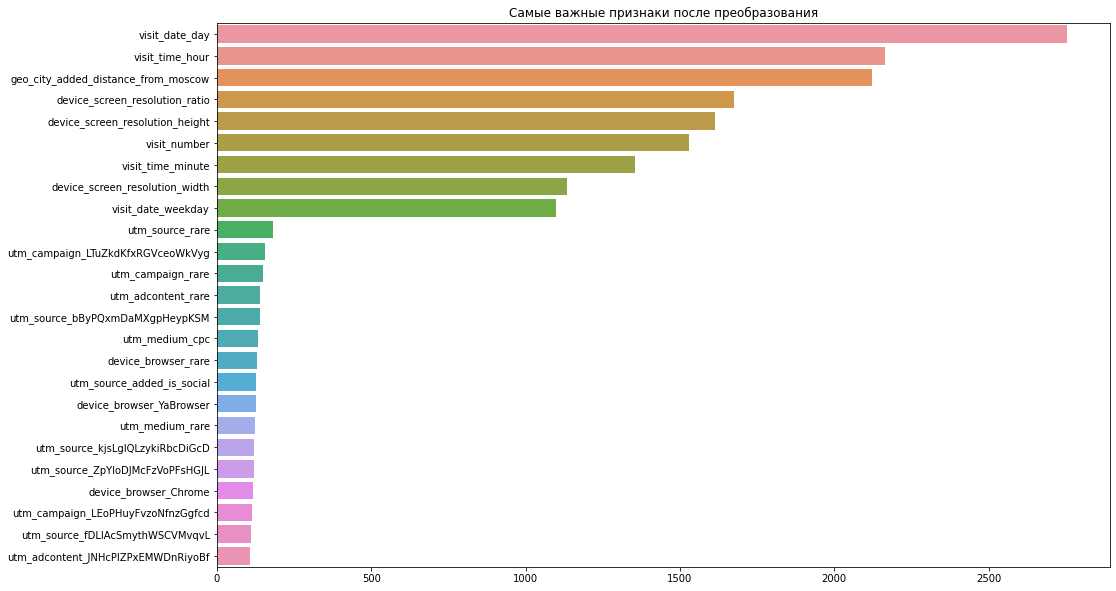

In [80]:
plt.figure(figsize=(16, 10))
most_important = feature_importance.sort_values(ascending=False).head(25)
sns.barplot(x=most_important, y=most_important.index, orient='h')
plt.title('Самые важные признаки после преобразования');

In [69]:
# Из важности производных признаков получим важность оригинальных
# Также получим важность признаков с добавленными данными

original_columns = list(sessions.columns) + ['_added_']
column_importances = list()
for col in original_columns:
    imp = feature_importance[feature_importance.index.str.contains(col)].sum()
    column_importances.append(imp)

column_importances = pd.Series(column_importances, index=original_columns)
column_importances.sort_values(ascending=False, inplace=True)

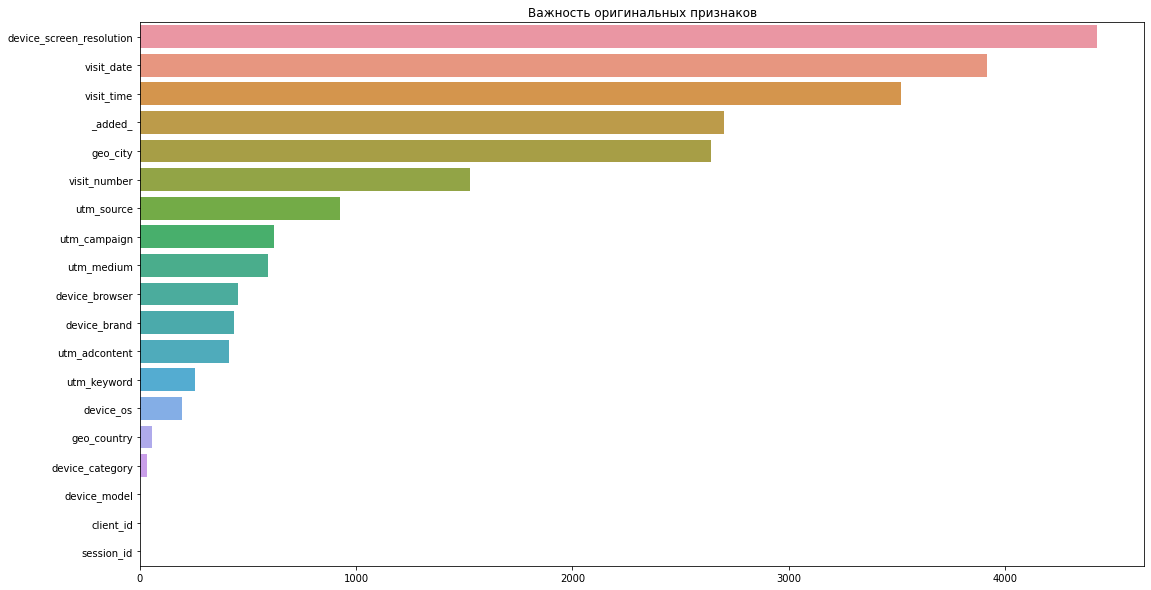

In [70]:
plt.figure(figsize=(18, 10))
sns.barplot(x=column_importances, y=column_importances.index, orient='h')
plt.title('Важность оригинальных признаков');

### Сохранение модели

In [88]:
# Объединим препроцессор и модель обратно

final_pipeline = final_preprocessor.set_params(model=final_model)

In [89]:
# Добавим метаданные для модели

metadata = {
    'name': 'SberAutopodpiska: target event prediction', 
    'descripton': ('Модель по предсказанию совершения пользователем одного из '
                   'целевых действий "Заказать звонок" или "Оставить заявку" '
                   'на сайте сервиса СберАвтоподписка.'), 
    'model_type': final_model.__class__.__name__, 
    'version': 1.0, 
    'training_datetime': datetime.now(), 
    'author': 'Nikolai Borziak', 
    'threshold': best_threshold, 
    'metrics': {
        'roc_auc': roc_auc_score(y_test, test_proba), 
        'roc_auc_by_class': roc_auc_score(y_test, test_prediction),
        'accuracy': accuracy_score(y_test, test_prediction), 
        'precision': precision_score(y_test, test_prediction), 
        'recall': recall_score(y_test, test_prediction), 
        'f1': f1_score(y_test, test_prediction),
    }
}

final_pipeline.metadata = metadata

In [90]:
# Сохраним модель

models_folder.mkdir(exist_ok=True)
filename = f'model_{datetime.now():%Y%m%d%H%M%S}.pkl'

with open(models_folder / filename, 'wb') as file:
    dill.dump(final_pipeline, file)

## Выводы

Для преобразования входных данных, со структурой как в файле `ga_sessions.csv`, в удобный для предсказания вид понадобилось четыре этапа:
1. Заполнение пропусков и генерация признаков. В том числе добавление новых данных, как-то органический трафик или расстояние до Москвы.
2. Преобразование численных переменных: нормализация и удаление выбросов.
3. Преобразование категориальных признаков. Основная сложность с ними была в многообразии редких уникальных значений. В итоге только самые популярные значения были закодированы методом one-hot.
4. Удаление дублирующих и коррелируемых признаков. Признаки могут коррелировать до 0.95, но именно с таким порогом финальная модель даёт лучший результат.

Было проверено 10 моделей с гиперпараметрами по умолчанию. В тройке лучших оказались алгоритмы бустинга от sklearn, lightgbm и catboost.

В итоге в качестве лучшей модели был выбран `LightGBM` по следующим причинам: 
+ Один из лучших показателей `roc_auc`.
+ Быстрое обучение. 
+ Модель интерпретируема, то есть можно получить показатели важности признаков.
+ Может предсказывать вероятность класса.
+ Нет проблем с процессорами без SSE4 как у CatBoost.

Шаг оптимизации модели помог выбрать лучшие гиперпараметры для модели: n_estimators=800, learning_rate=0.07, reg_lambda=10, num_leaves=26, reg_alpha=10, boosting_type='goss'.

Качество модели по метрике `roc-auc` составляет **0.7148** (0.6535 при предсказании классов). Но метрика `f1`=0.0871 оставляет желать лучшего. Тем не менее, переобучения нет и цель проекта выполнена - `roc-auc` > 0.65.

Для улучшения качества предсказания можно было бы: 
1. Увеличить количество данных. Тестовая выборка пойдёт на дообучение модели, так что может модель будет лучше в конечном итоге.
2. Провести ребалансировку классов. Но если уменьшить выборку с отрицательной целевой переменной, то модель теряет в качестве, а если увеличивать выборку с положительным классом, то модели обучаются слишком долго. 
3. Провести более тщательный поиск наилучших гиперпараметров - это займёт много времени, а прирост качества будет небольшим. 
4. Провести дополнительную генерацию признаков. Но хорошие идеи придумывать сложно.
5. Попробовать более сложные модели, например, нейронные сети глубокого обучения. 